# Milestone III

In [77]:
import pandas as pd
import joblib
import numpy as np
import re
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
import nltk
from collections import Counter
from textstat import textstat
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Ignore warnings
warnings.filterwarnings('ignore')


### Załadowanie zbioru z poprzedniego Milestone (inżynieria cech i preprocessing danych)

In [ ]:
df = joblib.load('processed_data.pkl')
df
# Wystarczy użyć analogicznie 

,Comment,Sentiment,Comment_preprocessed,Sentiment_Score_nltk,Starts_with_i,Comment_Length,Personal_Pronoun_count,Readability_Score,Negation_Count,Number_of_phrases,Number_of_words,Avg_phrase_length,Avg_word_length,Unique_word_ratio,Rare_Word_Count
0,156 wow the accuracy to make that ball come ba...,neutral,wow accuracy make ball back needed rim impres...,0.7184,False,158,3,64.38,0,4,34,8.500000,3.735294,0.941176,4
1,i thought the content and editing of this docu...,negative,content editing docu agonising overly intrusiv...,-0.7280,True,418,4,3.81,0,7,75,10.714286,4.586667,0.773333,13
2,awesome your potential seems limitless putting...,positive,awesome potential limitless putting fund inves...,0.8555,False,229,1,33.92,0,2,37,18.500000,5.216216,0.864865,4
3,love the smooth chillptsd go awayjust let me b...,positive,love smooth chillptsd awayjust beas thankyou tune,0.6369,False,79,1,99.57,0,1,14,14.000000,4.714286,0.928571,4
4,timestamps 059 hans vs liem 326 hans vs liem 8...,neutral,timestamps v liem v liem levon v alireza d...,0.8126,False,235,0,41.71,0,1,46,46.000000,4.130435,0.565217,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15600,i love this song,positive,love song,0.6369,True,17,1,118.18,0,1,4,4.000000,3.250000,1.000000,0
15601,the only thing i thing needs upgrade is the si...,neutral,upgrade site navigation newbie,0.0000,False,71,1,66.74,0,1,13,13.000000,4.538462,0.846154,2
15602,love our viking brothers that rulled us during...,positive,love viking brother rulled kyivenrus grets ukr...,0.6369,False,75,2,67.76,0,2,12,6.000000,5.333333,1.000000,4
15603,lets appreciate how he is making us happy and ...,positive,let appreciate making happy suffering oder,0.5106,False,73,2,66.74,0,2,13,6.500000,4.615385,1.000000,1


### Inżynieria cech

In [70]:
# Funkcja do obliczania Sentiment Score za pomocą NLTK
sia = SentimentIntensityAnalyzer()
def sentiment_score(comment):
    return sia.polarity_scores(comment)['compound']

# Funkcja do liczenia liczby zaimków osobistych
personal_pronouns = {"i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves",
                     "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself",
                     "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
                     "theirs", "themselves"}

def count_personal_pronouns(comment):
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in personal_pronouns)
# Funkcja do analizy złożoności zdań (np. liczba fraz, słów)
connectors = ["and", "but", "so", "because", "which", "that", "then", "if", "or"]
def sentence_complexity(comment):
    words = word_tokenize(comment)
    phrases = re.split(r'\b(?:' + '|'.join(connectors) + r')\b', comment)

    num_words = len(words)
    num_phrases = len(phrases)

    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    avg_phrase_length = num_words / num_phrases if num_phrases > 0 else 0
    unique_word_ratio = len(set(words)) / num_words if num_words > 0 else 0

    return {
        "Number_of_phrases": num_phrases,
        "Number_of_words": num_words,
        "Avg_phrase_length": avg_phrase_length,
        "Avg_word_length": avg_word_length,
        "Unique_word_ratio": unique_word_ratio
    }
# Funkcja do obliczania readability score
def readability_score(comment):
    return textstat.flesch_reading_ease(comment)
# Funkcja do liczenia negacji
def negation_count(comment):
    negations = {"not", "never", "no", "none", "cannot", "nothing","dont","nah",'wont','cant','doesnt','shouldnt',"shouldn't","doesn't"
                 "don't","won't","wouldn't", "can't","nobody",'neither','nope',"ain't","nowhere",'wouldnt'}
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in negations)
# Funkcja do liczenia rzadkich słów
def rare_word_count(comment, all_words):
    words = word_tokenize(comment.lower())
    rare_words = [word for word in words if all_words[word] < 10]  # Możemy dostosować próg (tutaj <10)
    return len(rare_words)

def prepare_features(df):
    # Usuń istniejące kolumny jeśli są, żeby uniknąć duplikatów
    cols_to_drop = [
        'Sentiment_Score_nltk',
        'Starts_with_i',
        'Comment_Length',
        'Personal_Pronoun_count',
        'Readability_Score',
        'Avg_phrase_length',
        'Avg_word_length',
        'Rare_Word_Count'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns], errors='ignore')

    # ...reszta Twojej funkcji jak wcześniej
    df['Comment'] = df['Comment'].fillna('').astype(str)

    df['Sentiment_Score_nltk'] = df['Comment'].apply(sentiment_score)
    df['Starts_with_i'] = df['Comment'].str.startswith("i")
    df['Comment_Length'] = df['Comment'].str.len()
    df["Personal_Pronoun_count"] = df["Comment"].apply(count_personal_pronouns)
    df["Readability_Score"] = df["Comment"].apply(readability_score)
    df["Negation_Count"] = df["Comment"].apply(negation_count)

    df_complexity = df["Comment"].apply(lambda x: sentence_complexity(x))
    df_complexity = pd.DataFrame(df_complexity.tolist(), index=df.index)
    df = pd.concat([df, df_complexity], axis=1)

    all_words = Counter(' '.join(df['Comment']).lower().split())
    df['Rare_Word_Count'] = df['Comment'].apply(lambda x: rare_word_count(x, all_words))

    return df

### PCA

In [ ]:

def apply_pca(df, n_components=5):
    # Wybieramy tylko kolumny numeryczne, które są cechami
    feature_cols = [
        'Sentiment_Score_nltk',
        'Starts_with_i',
        'Comment_Length',
        'Personal_Pronoun_count',
        'Readability_Score',
        'Avg_phrase_length',         # zakładam że to pochodzi z sentence_complexity
        'Avg_word_length',  # też z sentence_complexity
        'Rare_Word_Count'
    ]

    # Konwersja boola na int
    df['Starts_with_i'] = df['Starts_with_i'].astype(int)

    # Standaryzacja
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[feature_cols])

    # PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Zastąpienie oryginalnych cech PCA komponentami
    for i in range(n_components):
        df[f'PCA_{i+1}'] = X_pca[:, i]

    # Możesz usunąć oryginalne kolumny, jeśli chcesz tylko PCA:
    df = df.drop(columns=feature_cols)

    return df, pca, scaler, X_scaled

In [56]:
raw_df = df
df, pca_model, scaler, X_scaled = apply_pca(df)

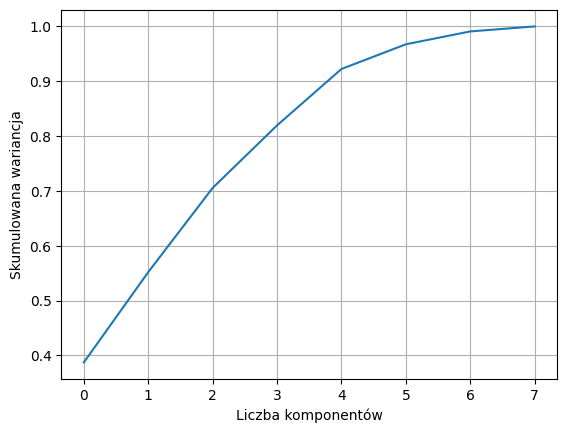

In [57]:
pca = PCA().fit(X_scaled)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained)
plt.xlabel('Liczba komponentów')
plt.ylabel('Skumulowana wariancja')
plt.grid(True)
plt.show()

Widać, że liczba komponentów po osiągnięciu 5 nie wpływa znacząco na wzrost wariancji, dlatego wybierzemy tą liczbę komponentów przy pca.

In [ ]:
df = raw_df
feature_cols = [
        'Sentiment_Score_nltk',
        'Starts_with_i',
        'Comment_Length',
        'Personal_Pronoun_count',
        'Readability_Score',
        'Avg_phrase_length',         
        'Avg_word_length',  
        'Rare_Word_Count'
    ]
# Standaryzacja
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[-2.77354165e-01,  3.06817604e-01, -8.29237582e-02,
        -8.85446919e-01, -5.81794849e-02],
       [ 1.29583786e+00, -3.42288542e-01, -1.32164059e-01,
         2.88487547e+00, -8.73252941e-01],
       [ 2.38710107e-01, -1.53124034e-01,  2.73687835e-01,
        -9.84486947e-01,  7.45665155e-01],
       ...,
       [-5.97217831e-01,  1.27881313e-03,  4.62350998e-01,
        -6.95801292e-01,  6.59338947e-02],
       [-7.58263851e-01,  2.28334905e-03,  2.90184510e-01,
        -5.68931161e-01, -1.74699014e-01],
       [-5.30272684e-01,  1.13589934e+00, -5.46949356e-02,
         1.27207639e+00,  7.43056309e-01]], shape=(15605, 5))

### Porównanie różnych modeli

              precision    recall  f1-score   support

    negative       0.52      0.61      0.56       614
     neutral       0.57      0.66      0.61      1184
    positive       0.89      0.81      0.85      2884

    accuracy                           0.74      4682
   macro avg       0.66      0.69      0.67      4682
weighted avg       0.76      0.74      0.75      4682

Accuracy: 0.7424
F2-score (macro): 0.6832
F2-score (weighted): 0.7448


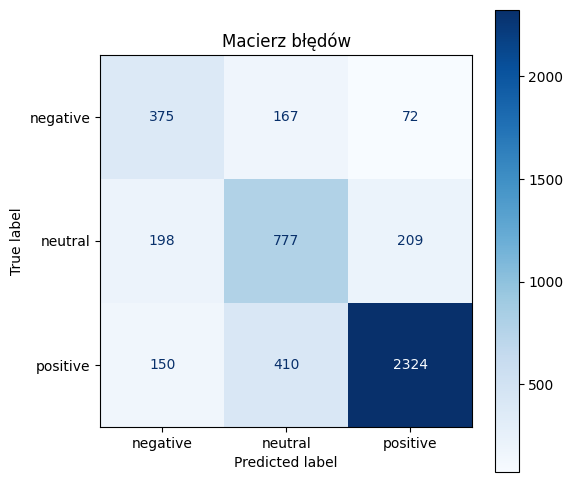

In [79]:
# --- 1. Podział danych
df_train, df_test = train_test_split(df, test_size=0.3, random_state=0)

X_train = df_train.drop(columns=['Sentiment'])
y_train = df_train['Sentiment']
X_test = df_test.drop(columns=['Sentiment'])
y_test = df_test['Sentiment']

# --- 2. Funkcja do przygotowania cech
def feature_and_text_extractor(df):
    df = prepare_features(df)
    return df

# --- 3. Pipeline: TF-IDF + PCA (z cech liczbowych)
feature_cols = [
    'Sentiment_Score_nltk',
    'Starts_with_i',
    'Comment_Length',
    'Personal_Pronoun_count',
    'Readability_Score',
    'Avg_phrase_length',
    'Avg_word_length',
    'Rare_Word_Count'
]

preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(), 'Comment_preprocessed'),
    ('numeric_pca', Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=5))
    ]), feature_cols)
])

# --- 4. Finalny pipeline z SMOTE i modelem
pipe = ImbPipeline(steps=[
    ('prepare', FunctionTransformer(feature_and_text_extractor, validate=False)),
    ('features', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# --- 5. Trening i ewaluacja
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
f2_macro = fbeta_score(y_test, y_pred, beta=2, average='macro')
f2_weighted = fbeta_score(y_test, y_pred, beta=2, average='weighted')

print(f"F2-score (macro): {f2_macro:.4f}")
print(f"F2-score (weighted): {f2_weighted:.4f}")

# 1. Obliczenie macierzy
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# 2. Wyświetlenie
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów")
plt.show()

              precision    recall  f1-score   support

    negative       0.50      0.65      0.57       614
     neutral       0.59      0.63      0.61      1184
    positive       0.89      0.81      0.85      2884

    accuracy                           0.74      4682
   macro avg       0.66      0.70      0.68      4682
weighted avg       0.76      0.74      0.75      4682

Accuracy: 0.7441
F2-score (macro): 0.6880
F2-score (weighted): 0.7464


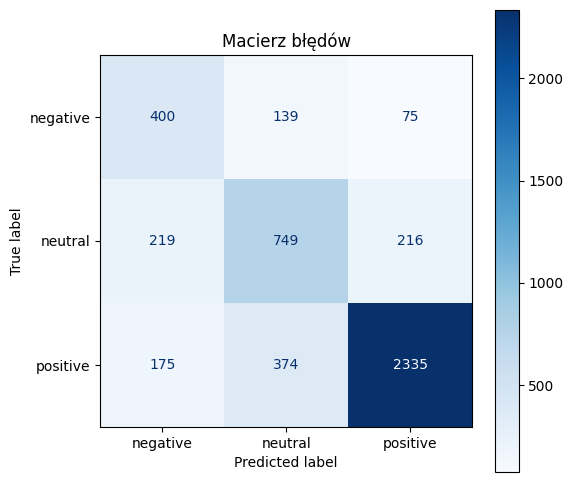

In [80]:
# --- 4. Finalny pipeline z SMOTE i modelem
pipe = ImbPipeline(steps=[
    ('prepare', FunctionTransformer(feature_and_text_extractor, validate=False)),
    ('features', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000, penalty='l2', solver='liblinear'))
])

# --- 5. Trening i ewaluacja
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
f2_macro = fbeta_score(y_test, y_pred, beta=2, average='macro')
f2_weighted = fbeta_score(y_test, y_pred, beta=2, average='weighted')

print(f"F2-score (macro): {f2_macro:.4f}")
print(f"F2-score (weighted): {f2_weighted:.4f}")
# 1. Obliczenie macierzy
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# 2. Wyświetlenie
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów")
plt.show()

              precision    recall  f1-score   support

    negative       0.49      0.60      0.54       614
     neutral       0.55      0.68      0.61      1184
    positive       0.90      0.77      0.83      2884

    accuracy                           0.73      4682
   macro avg       0.65      0.68      0.66      4682
weighted avg       0.76      0.73      0.74      4682

Accuracy: 0.7273
F2-score (macro): 0.6734
F2-score (weighted): 0.7303


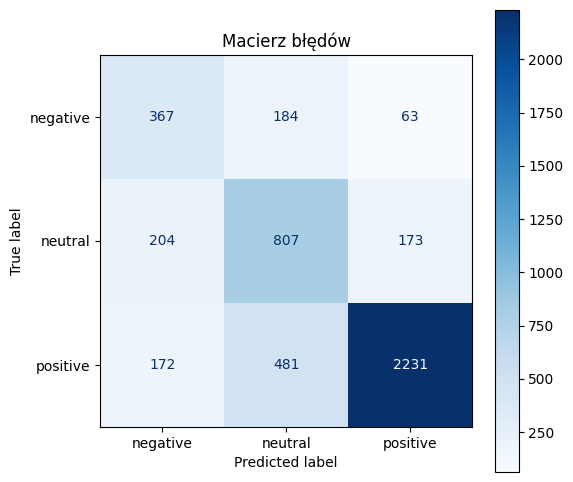

In [81]:
# --- 4. Finalny pipeline z SMOTE i modelem
pipe = ImbPipeline(steps=[
    ('prepare', FunctionTransformer(feature_and_text_extractor, validate=False)),
    ('features', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear'))
])

# --- 5. Trening i ewaluacja
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
f2_macro = fbeta_score(y_test, y_pred, beta=2, average='macro')
f2_weighted = fbeta_score(y_test, y_pred, beta=2, average='weighted')

print(f"F2-score (macro): {f2_macro:.4f}")
print(f"F2-score (weighted): {f2_weighted:.4f}")
# 1. Obliczenie macierzy
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# 2. Wyświetlenie
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów")
plt.show()

              precision    recall  f1-score   support

    negative       0.46      0.70      0.55       614
     neutral       0.59      0.61      0.60      1184
    positive       0.90      0.79      0.84      2884

    accuracy                           0.73      4682
   macro avg       0.65      0.70      0.67      4682
weighted avg       0.76      0.73      0.74      4682

Accuracy: 0.7330
F2-score (macro): 0.6823
F2-score (weighted): 0.7357


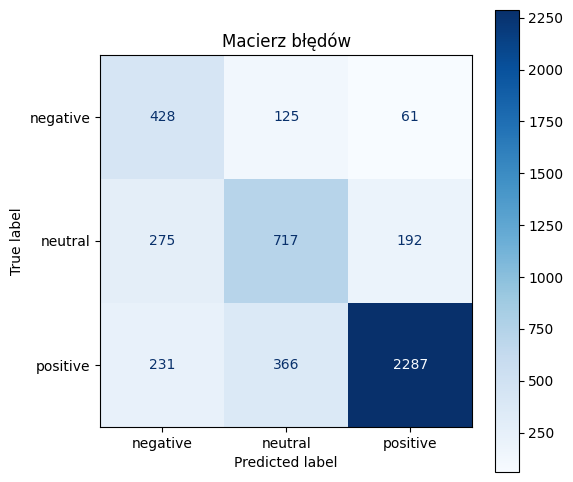

In [83]:
# --- 4. Finalny pipeline z SMOTE i modelem
pipe = ImbPipeline(steps=[
    ('prepare', FunctionTransformer(feature_and_text_extractor, validate=False)),
    ('features', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight={'negative': 2, 'neutral': 1, 'positive': 1}))
])

# --- 5. Trening i ewaluacja
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
f2_macro = fbeta_score(y_test, y_pred, beta=2, average='macro')
f2_weighted = fbeta_score(y_test, y_pred, beta=2, average='weighted')

print(f"F2-score (macro): {f2_macro:.4f}")
print(f"F2-score (weighted): {f2_weighted:.4f}")
# 1. Obliczenie macierzy
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])

# 2. Wyświetlenie
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów")
plt.show()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Najlepsze parametry: {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 0.1, 'classifier__class_weight': {'negative': 2, 'neutral': 1, 'positive': 1}}
              precision    recall  f1-score   support

    negative       0.35      0.84      0.50       614
     neutral       0.62      0.41      0.50      1184
    positive       0.90      0.76      0.82      2884

    accuracy                           0.68      4682
   macro avg       0.62      0.67      0.61      4682
weighted avg       0.76      0.68      0.70      4682

Accuracy: 0.6822
F2-score (macro): 0.6281
F2-score (weighted): 0.6810


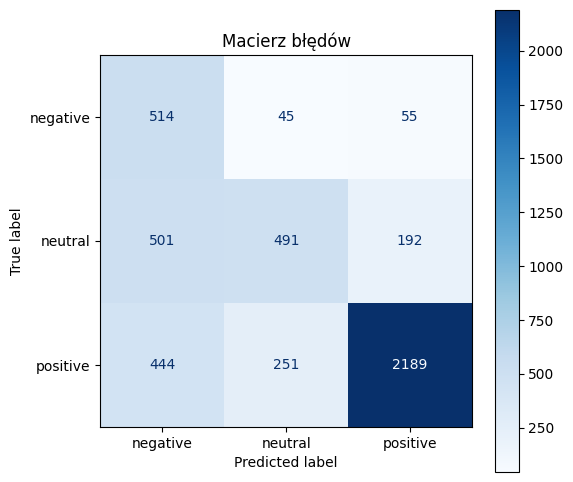

In [84]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, recall_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# --- 1. Twoje feature columns i preprocessor
feature_cols = [
    'Sentiment_Score_nltk',
    'Starts_with_i',
    'Comment_Length',
    'Personal_Pronoun_count',
    'Readability_Score',
    'Avg_phrase_length',
    'Avg_word_length',
    'Rare_Word_Count'
]

preprocessor = ColumnTransformer(transformers=[
    ('tfidf', TfidfVectorizer(), 'Comment_preprocessed'),
    ('numeric_pca', SklearnPipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=5))
    ]), feature_cols)
])

# --- 2. Pipeline bazowy bez klasyfikatora
base_pipeline = ImbPipeline(steps=[
    ('prepare', FunctionTransformer(feature_and_text_extractor, validate=False)),
    ('features', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression())  # Placeholder — zostanie nadpisany
])

# --- 3. Parametry do przetestowania
param_grid = [
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1, 10],
        'classifier__class_weight': [
            'balanced',
            {'negative': 2, 'neutral': 1, 'positive': 1}
        ]
    },
    {
        'classifier': [RandomForestClassifier(random_state=0)],
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')],
        'classifier__n_estimators': [100],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.1]
    },
    {
        'classifier': [SVC(probability=True)],
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear']
    }
]

# --- 4. Własny scorer: recall tylko dla klasy 'negative'
def negative_recall_score(y_true, y_pred):
    return recall_score(y_true, y_pred, labels=['negative'], average='macro')

neg_recall_scorer = make_scorer(negative_recall_score)

# --- 5. GridSearchCV
grid = GridSearchCV(
    estimator=base_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=neg_recall_scorer,
    n_jobs=-1,
    verbose=2
)

# --- 6. Trening
grid.fit(X_train, y_train)

# --- 7. Ewaluacja
y_pred = grid.predict(X_test)

print("Najlepsze parametry:", grid.best_params_)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F2-score (macro): {fbeta_score(y_test, y_pred, beta=2, average='macro'):.4f}")
print(f"F2-score (weighted): {fbeta_score(y_test, y_pred, beta=2, average='weighted'):.4f}")

# --- 8. Macierz błędów
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów")
plt.show()

              precision    recall  f1-score   support

    negative       0.54      0.52      0.53       614
     neutral       0.55      0.67      0.60      1184
    positive       0.88      0.80      0.84      2884

    accuracy                           0.73      4682
   macro avg       0.65      0.66      0.66      4682
weighted avg       0.75      0.73      0.74      4682

Accuracy: 0.7317
F2-score (macro): 0.6602
F2-score (weighted): 0.7335


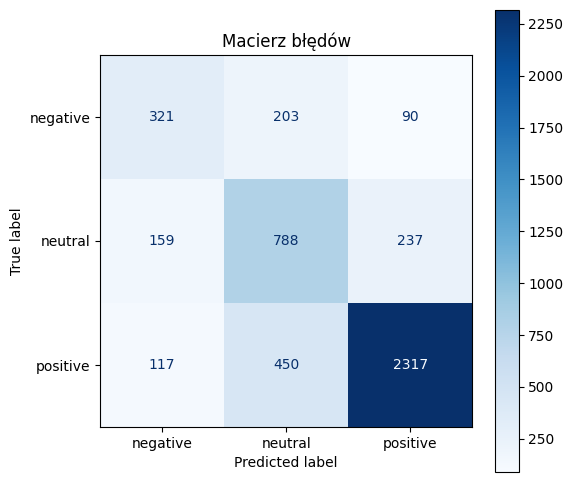

In [86]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import LabelEncoder

# --- 1. Zamiana etykiet tekstowych na numeryczne
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)  # 'negative' -> 0, 'neutral' -> 1, 'positive' -> 2
y_test_encoded = le.transform(y_test)

# --- 2. Baza modeli
estimators = [
    ('lr', LogisticRegression(C=0.1, max_iter=1000, class_weight={0: 2, 1: 1, 2: 1})),  # Używamy klas numerycznych
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=100, max_depth=6)),
]

# --- 3. Model meta (Logistic Regression jako meta-model)
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=3,
    n_jobs=-1
)

# --- 4. Finalny pipeline
stacking_pipe = ImbPipeline(steps=[
    ('prepare', FunctionTransformer(feature_and_text_extractor, validate=False)),
    ('features', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('classifier', stacking_clf)
])

# --- 5. Trening
stacking_pipe.fit(X_train, y_train_encoded)

# --- 6. Predykcje
y_pred_encoded = stacking_pipe.predict(X_test)

# --- 7. Wrócenie do etykiet tekstowych (negatyw, neutralny, pozytywny)
y_pred = le.inverse_transform(y_pred_encoded)

# --- 8. Ewaluacja
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F2-score (macro): {fbeta_score(y_test, y_pred, beta=2, average='macro'):.4f}")
print(f"F2-score (weighted): {fbeta_score(y_test, y_pred, beta=2, average='weighted'):.4f}")
# --- 8. Macierz błędów
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów")
plt.show()

In [87]:
best_model = ImbPipeline(steps=[
    ('prepare', FunctionTransformer(feature_and_text_extractor, validate=False)),
    ('features', preprocessor),
    ('smote', SMOTE(random_state=0)),
    ('classifier', LogisticRegression(max_iter=1000, C=0.1, class_weight={'negative': 2, 'neutral': 1, 'positive': 1}))
])

best_model.fit(X_train, y_train)

Pipeline(steps=[('prepare',
                 FunctionTransformer(func=<function feature_and_text_extractor at 0x00000221113E5800>)),
                ('features',
                 ColumnTransformer(transformers=[('tfidf', TfidfVectorizer(),
                                                  'Comment_preprocessed'),
                                                 ('numeric_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['Sentiment_Score_nltk',
                                                   'Starts_with_i',
                                                   'Comment_Length',
                                                   'Personal_Pronoun_count',
                                                   'Readability_Score',
                                                   'Avg_phrase_length',
                                                   'Avg_word_length',
                                                   'Rare_Word_Count'])])),
                ('smote', SMOTE(random_state=0)),
                ('classifier',
                 LogisticRegression(C=0.1,
                                    class_weight={'negative': 2, 'neutral': 1,
                                                  'positive': 1},
                                    max_iter=1000))])

📌 Najlepszy próg dla 'negative': 0.45
Precision: 0.3505, Recall: 0.8420, F2: 0.6576


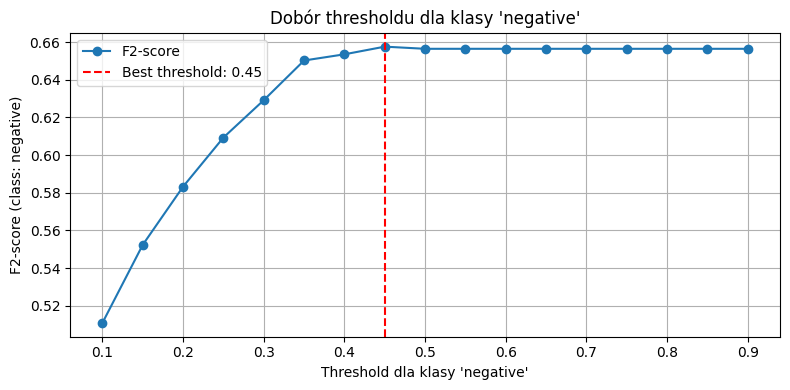

              precision    recall  f1-score   support

    negative       0.35      0.84      0.49       614
     neutral       0.62      0.41      0.49      1184
    positive       0.90      0.76      0.82      2884

    accuracy                           0.68      4682
   macro avg       0.62      0.67      0.60      4682
weighted avg       0.76      0.68      0.70      4682



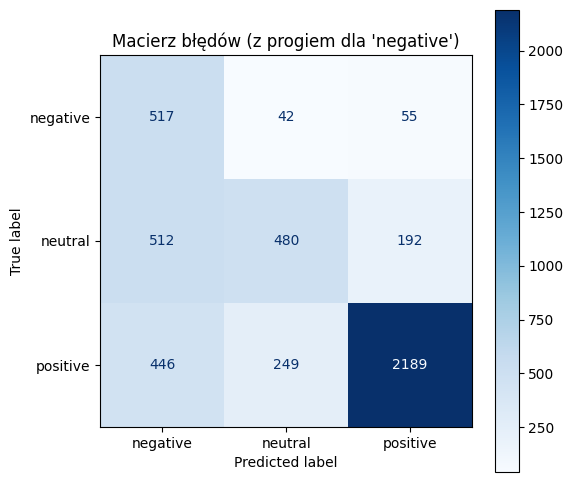

In [90]:
thresholds = np.arange(0.1, 0.91, 0.05)
scores = []

for thresh in thresholds:
    y_pred_thresh = []
    for i in range(len(y_proba)):
        if y_proba[i][neg_index] >= thresh:
            y_pred_thresh.append('negative')
        else:
            y_pred_thresh.append(classes[np.argmax(y_proba[i])])
    
    # 🔄 Zrób z tego klasy binarne: 'negative' vs 'other'
    y_test_binary = ['negative' if label == 'negative' else 'other' for label in y_test]
    y_pred_binary = ['negative' if label == 'negative' else 'other' for label in y_pred_thresh]
    
    precision = precision_score(y_test_binary, y_pred_binary, pos_label='negative', average='binary')
    recall = recall_score(y_test_binary, y_pred_binary, pos_label='negative', average='binary')
    f2 = fbeta_score(y_test_binary, y_pred_binary, beta=2, pos_label='negative', average='binary')
    
    scores.append((thresh, precision, recall, f2))
# Najlepszy próg
best = max(scores, key=lambda x: x[3])
best_thresh = best[0]
print(f"📌 Najlepszy próg dla 'negative': {best_thresh:.2f}")
print(f"Precision: {best[1]:.4f}, Recall: {best[2]:.4f}, F2: {best[3]:.4f}")

# Wykres
plt.figure(figsize=(8, 4))
plt.plot(thresholds, [x[3] for x in scores], marker='o', label='F2-score')
plt.axvline(best_thresh, color='r', linestyle='--', label=f'Best threshold: {best_thresh:.2f}')
plt.xlabel("Threshold dla klasy 'negative'")
plt.ylabel("F2-score (class: negative)")
plt.title("Dobór thresholdu dla klasy 'negative'")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

    # Finalna predykcja
y_pred_custom = []
for i in range(len(y_proba)):
    if y_proba[i][neg_index] >= best_thresh:
        y_pred_custom.append('negative')
    else:
        y_pred_custom.append(classes[np.argmax(y_proba[i])])

# Ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred_custom, labels=['negative', 'neutral', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title("Macierz błędów (z progiem dla 'negative')")
plt.show()
